In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc1

!pip install -q h5py pyyaml

In [0]:
# mount to your google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

from PIL import Image

import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Input
from tensorflow.keras.preprocessing import image

import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import cv2

print(tf.__version__)

2.0.0-rc1


##Data load(train, validation, test)

In [0]:
PATH = "/content/gdrive/My Drive/dataset"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_cats_test = len(os.listdir(test_cats_dir))
num_dogs_test = len(os.listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test= num_cats_test + num_dogs_test

print(total_train)
print(total_val)
print(total_test)

17000
4000
4000


##Visualize with each data graph

In [0]:
# 데이터 확인 함수
def check_images(train_path, val_path, test_path):
  train_cat_path = os.path.join(train_path,"cat")
  train_dog_path = os.path.join(train_path,"dog")
  val_cat_path = os.path.join(val_path,"cat")
  val_dog_path = os.path.join(val_path,"dog")
  test_cat_path = os.path.join(test_path,"cat")
  test_dog_path = os.path.join(test_path,"dog")

  num_cats_tr = len(os.listdir(train_cat_path))
  num_dogs_tr = len(os.listdir(train_dog_path))
  num_cats_val = len(os.listdir(val_cat_path))
  num_dogs_val = len(os.listdir(val_dog_path))
  num_cats_test = len(os.listdir(test_cat_path))
  num_dogs_test = len(os.listdir(test_dog_path))
  label = ['train', 'valid','test']
  cat = [num_cats_tr,num_cats_val,num_cats_test]
  dog = [num_dogs_tr,num_dogs_val,num_dogs_test]

  plt.rcParams["font.size"] = 12

  plt.figure(figsize=(12,8))

  x = np.arange(len(label))

  p1 = plt.bar(x-0.15, cat, label='cat', width=0.3, color='#FFE6EB')
  p2 = plt.bar(x+0.15, dog, label='dog', width=0.3, color='#36E0C6')

  for i, rect in enumerate(p1):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(cat[i]), ha='center')
  for i, rect in enumerate(p2):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(dog[i]), ha='center')
  plt.legend((p1[0], p2[0]), ('1','0'), fontsize = 15)

  plt.xticks(x, label)
  plt.ylabel('Number of data')
  plt.title('Dogs-vs-Cats Data')

  plt.show()
  return

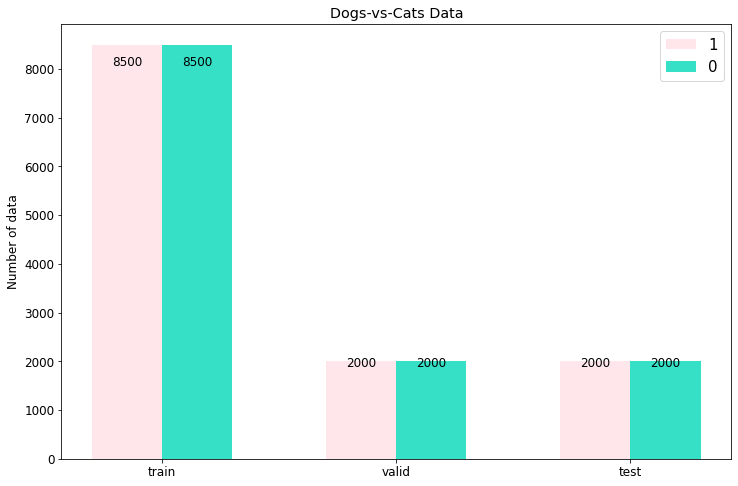

In [0]:
check_images(train_dir, validation_dir, test_dir)

##Hyperparameter initialization and dataset, load configuration

In [0]:
#하이퍼파라미터 초기화
batch_size = 20
epochs = 550
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [0]:
train_image_generator = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 17000 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 4000 images belonging to 2 classes.


In [0]:
test_dir = pathlib.Path(test_dir)

CLASS_NAMES = np.array([item.name for item in test_dir.glob('*') if item.name != "LICENSE.txt"])

In [0]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              classes=list(CLASS_NAMES))

Found 4000 images belonging to 2 classes.


In [0]:
#model 구성

input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input')

## Model design, detailed configuration of model-related parameter(optimization, loss function, metrics, etc.)

In [0]:
#Conv Layer

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    return x  

In [0]:
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)    
    shortcut = x
    for i in range(3):
        x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)  
        x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
        if i == 0 :
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
        else :
            x = BatchNormalization()(x)        
        x = Add()([x, shortcut])   
        x = Activation('relu')(x)  
        shortcut = x        
    return x

In [0]:
def conv3_layer(x):        
    shortcut = x       
    for i in range(4):
        if(i == 0):                
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)          
        x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x) 
        x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
        if(i == 0):
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut) 
        else:
            x = BatchNormalization()(x)           
        x = Add()([x, shortcut])    
        x = Activation('relu')(x)    
        shortcut = x                    
    return x

In [0]:
def conv4_layer(x):
    shortcut = x  
    for i in range(6):     
        if(i == 0):                
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
        if i==0 :
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
        else :
            x = BatchNormalization()(x)  
        x = Add()([x, shortcut])    
        x = Activation('relu')(x)
        shortcut = x      
    return x

In [0]:
def conv5_layer(x):
    shortcut = x    
    for i in range(3):     
        if(i == 0):                
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)     
        x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
        if i==0 :
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
        else :
            x = BatchNormalization()(x)                 
        x = Add()([x, shortcut]) 
        x = Activation('relu')(x)       
        shortcut = x                  
    return x

In [0]:
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(1, activation='sigmoid')(x)

In [0]:
Resnet50 = Model(input_tensor, output_tensor)

Resnet50.summary()

In [0]:
optimizer = optimizers.SGD(lr=0.001, momentum=0.9)

Resnet50.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

##Model learning (with parameters such as checkpoints, steps, epochs, data, etc.)

In [0]:
# #체크포인트 설정
# checkpoint_path = "/content/gdrive/My Drive/dataset/resnet_cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path, verbose=1, svae_weights_only=True,
#     period=45)

# Resnet50.save_weights(checkpoint_path.format(epoch=0))
history = Resnet50.fit_generator(
    train_data_gen,
    steps_per_epoch = 80,
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps = 20
    # callbacks = [cp_callback]
)

In [0]:
with open('/content/gdrive/My Drive/github_modelNet/all_resnet_550_history.bin', 'wb') as hi:
    pickle.dump(history.history, hi)

##View model learning graphs (550 epochs)

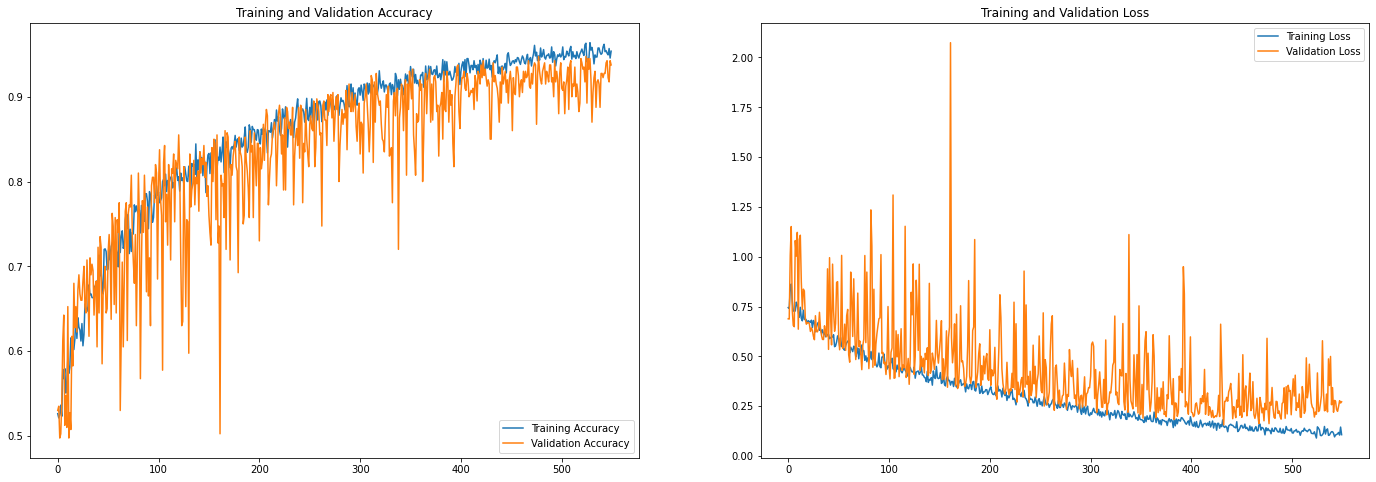

In [0]:
#550 epoch commit graph(train, validation - accracy, loss value)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Assess learning model and confirm prediction(250, 550 epoch)

In [0]:
#550 epoch train_step 80, val_step 20 결과
print("Evaluate")
scores = Resnet50.evaluate_generator(test_data_gen, steps=200, verbose=1)
print("%s: %.2f%%" %(Resnet50.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" %(Resnet50.metrics_names[0], scores[0]*100)) 

Evaluate
200/200 [==============================] - 28s 138ms/step - loss: 0.1592 - accuracy: 0.9385
accuracy: 93.85%
loss: 15.92%


In [0]:
Resnet50 = tf.keras.models.load_model('/content/gdrive/My Drive/dataset/resnet101_model_550.h5')

In [0]:
print("Predict")
pred = Resnet50.predict_generator(test_data_gen, steps=200, verbose=1)

Predict
200/200 [==============================] - 25s 127ms/step


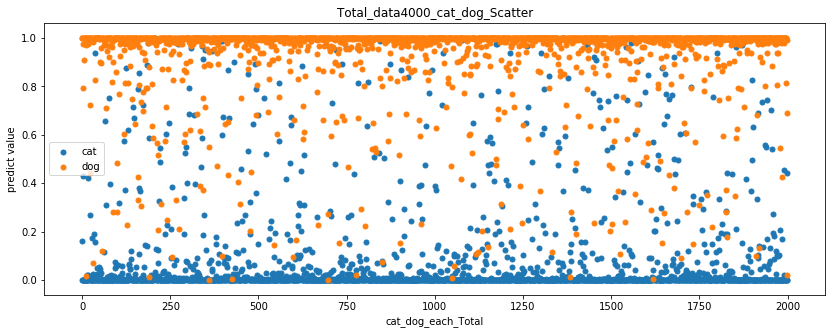

In [0]:
#test_ predict 예측값 분포도(4000개)

plt.figure(figsize=(14, 5))
plt.title('Total_data4000_cat_dog_Scatter')
plt.xlabel('cat_dog_each_Total')
plt.ylabel('predict value')
plt.scatter(range(2000), pred[:2000], s=25, label='cat')
plt.scatter(range(2000), pred[2000:], s=25, label='dog')
plt.legend()
plt.show()

In [0]:
#분류 작업

predict_data = []

for i in range(len(pred)):
  if pred[i] > 0.5:
    predict_data.append(1)
  else:
    predict_data.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

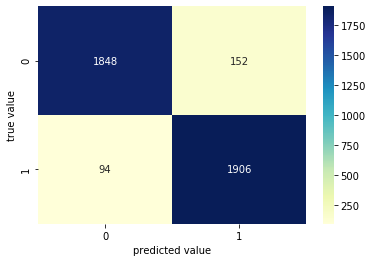

In [0]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(test_data_gen.classes, predict_data)
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

##Feature map (one layer or one layer each).

(1, 224, 224, 3)


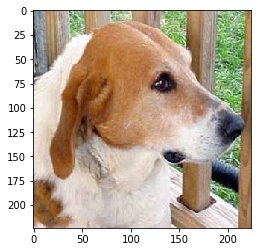

In [0]:
#feature map 

#test_image 한개 접근
test_image = Image.open('/content/gdrive/My Drive/dataset/test/dog/dog.68.jpg').resize((224, 224))

img_tensor = image.img_to_array(test_image)
img_tensor = np.expand_dims(img_tensor, axis=0)
test_data = img_tensor / 255.0


plt.imshow(test_image)

print(test_data.shape)

In [0]:
#모델 예측 확인
pred_test = Resnet50.predict(test_data)

print(pred_test)

[[0.99793845]]


In [0]:
def Layer_predict(model, image):
  output_layers = [layer.output for layer in model.layers[1:177] if 'conv2d' == '{}'.format(layer.name[:6])]
  output_names = [layer.name for layer in model.layers[1:177] if 'conv2d' == '{}'.format(layer.name[:6])]

  show_model = tf.keras.models.Model(inputs = model.input, outputs = output_layers)
  # 예측_A
  show_model_pred = show_model.predict(image)
  #print(model_A_pred[0])
  for k, pred_layer in enumerate(show_model_pred):
    print(k, pred_layer.shape)
  return show_model_pred, output_names

In [0]:
layer_outputs, layer_names = Layer_predict(Resnet50, test_data)

In [0]:
def show_predict_image(show_model_pred,output_names):
    n_col= 10
    _, size2, size, n_features = show_model_pred.shape
    n_row = n_features //n_col
    # feature_map_image = np.zeros(shape=(size2*n_row,size*n_col),dtype=('uint8'))
    feature_map_image = np.zeros(shape=(size2, size*n_col),dtype=('uint8'))
    
    for row in range(1):
        for col in range(n_col):   
            input_fmi = show_model_pred[0,:,:,row*n_col+col]

            input_fmi -= input_fmi.mean()
            input_fmi /= input_fmi.std()
            input_fmi *= 64
            input_fmi += 128
            input_fmi = np.clip(input_fmi, 0, 255).astype('uint8')

            feature_map_image[row*size2:(row+1)*size2, col*size:(col+1)*size] = input_fmi

    plt.figure(figsize=(n_col, n_row))
    plt.xticks([])
    plt.yticks([])
    plt.title('layer : {}'.format(output_names))
    plt.tight_layout()
    plt.imshow(feature_map_image,cmap='viridis')

In [0]:
for layer, name in zip(layer_outputs, layer_names):
  show_predict_image(layer, name)
plt.tight_layout()
plt.show()

In [0]:
#각 층의 1개의 피쳐 맵 가져오기
def show_activation_maps(layer, title, i, n_cols=10):
  plt.subplot(10, 11, i+1)
  plt.title('{}:{}'.format(i, title))
  plt.axis('off')
  plt.matshow(layer[0, :, :, i], fignum=0)

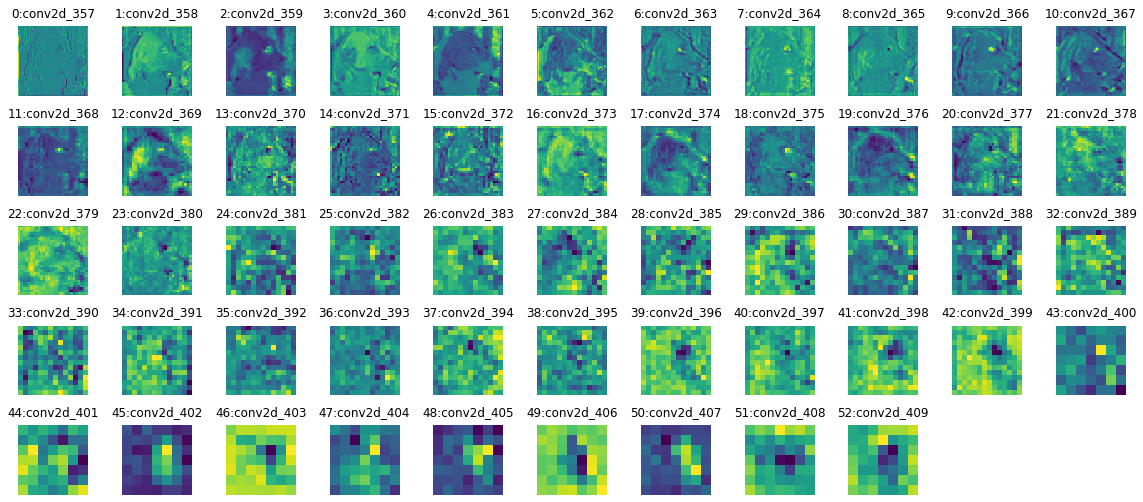

In [0]:
plt.figure(figsize=(16, 14))
for i, (layer, name) in enumerate(zip(layer_outputs, layer_names)):
  
  show_activation_maps(layer, name, i)
plt.tight_layout()
plt.show()

##Grad CAM(filter 512 conv_2d layer commit, cat, dog)

In [0]:
# 7, 7, 512 conv size commit(338, 325 Layer using)

for i in range(177):
  weights = Resnet50.get_layer(index=i).output

  print(i, weights)

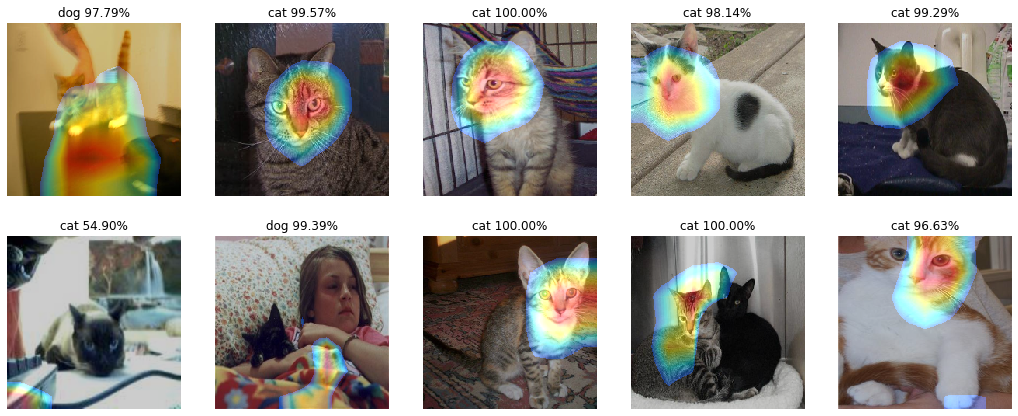

In [0]:
import cv2
plt.figure(figsize=(18, 15))
for i in range(10):
    img = cv2.imread('/content/gdrive/My Drive/dataset/test/cat/cat.%d.jpg'%i)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    x = img.copy()
    x.astype(np.float32)
    x = x / 255.0
    
    grad_model = tf.keras.models.Model(
        [Resnet50.inputs], [Resnet50.get_layer(index=171).output, Resnet50.output]
    )

    with tf.GradientTape() as tape:
      x = np.expand_dims(x, axis=0)
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

    grads = tape.gradient(loss, model_outputs)

    guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
    )

    prediction = predictions[0]
    base_model_outputs = model_outputs[0]
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    weights = np.mean(grads, axis=(1, 2))
    weights = weights.reshape(2048, 1)

    cam = (prediction) * np.matmul(base_model_outputs, weights)
    #cam -= np.min(cam)
    cam /= np.max(cam)
    cam -= 0.2
    cam /= 0.8
    
    cam = cv2.resize(np.float32(cam), (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
    plt.axis('off')
    plt.imshow(out[:,:,::-1])

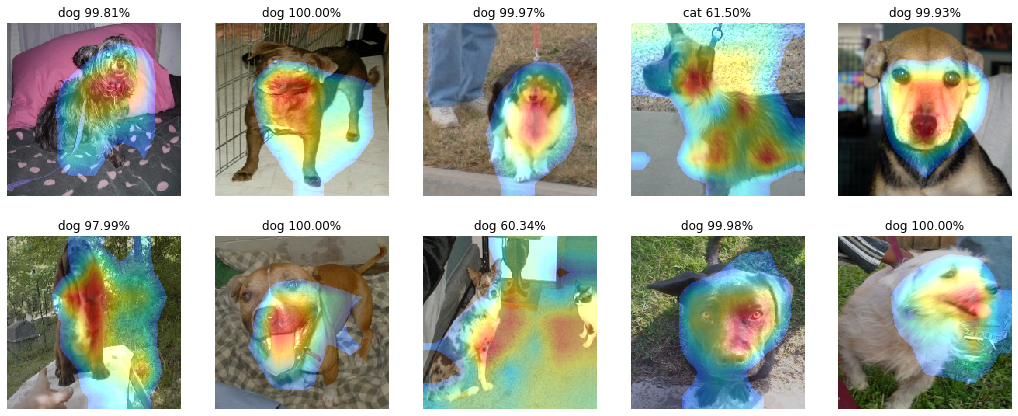

In [0]:
plt.figure(figsize=(18, 15))
for i in range(10):
    img = cv2.imread('/content/gdrive/My Drive/dataset/test/dog/dog.%d.jpg'%i)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    x = img.copy()
    x.astype(np.float32)
    x = x / 255.0
    
    grad_model = tf.keras.models.Model(
        [Resnet50.inputs], [Resnet50.get_layer(index=146).output, Resnet50.output]
    )

    with tf.GradientTape() as tape:
      x = np.expand_dims(x, axis=0)
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

    grads = tape.gradient(loss, model_outputs)

    guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
    )

    prediction = predictions[0]
    base_model_outputs = model_outputs[0]
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    weights = np.mean(grads, axis=(1, 2))
    weights = weights.reshape(512, 1)

    cam = (prediction -0.5) * np.matmul(base_model_outputs, weights)
    cam -= np.min(cam)
    cam /= np.max(cam)
    cam -= 0.2
    cam /= 0.8
    
    cam = cv2.resize(np.float32(cam), (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
    plt.axis('off')
    plt.imshow(out[:,:,::-1])